In [1]:
import local_models.local_models
import local_models.loggin
import local_models.TLS_models
import local_models.linear_projections
import local_models.utils
import local_models.algorithms
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import scipy.stats
import logging
import ml_battery.log
import time
import os
from IPython.display import Markdown as md
import joblib
import tqdm
import functools
import itertools

logger = logging.getLogger(__name__)

reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

def import_shit():
    import local_models.local_models
    import local_models.loggin
    import local_models.TLS_models
    import local_models.linear_projections
    import local_models.utils
    import local_models.algorithms
    import numpy as np
    import matplotlib.pyplot as plt
    import sklearn.linear_model
    import sklearn.cluster
    from importlib import reload
    from ml_battery.utils import cmap
    import matplotlib as mpl
    import sklearn.datasets
    import scipy.stats
    import logging
    import ml_battery.log
    import time
    import os
    from IPython.display import Markdown as md
    import joblib
    import itertools
    import functools

In [2]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [3]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [4]:
project_dir = "../data/moons_second_tls_01"
os.makedirs(project_dir, exist_ok=1)

In [5]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

def noisy_moons_maker(n=None, noise=None, seed=None, bandwidth=None, kernel=local_models.local_models.TriCubeKernel, invert=False):
    import_shit()
    NOISE_STEP=0.005
    noises = int(noise/NOISE_STEP)
    np.random.seed(seed)
    noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=0)
    for noise in range(noises): #so that we can move the same data a little bit at a time... i.e. noise 0.06 is only N(0,0.005) different than noise 0.055
        noisy_moons += np.random.normal(loc=0,scale=NOISE_STEP,size=(n,2))
    kernel_cb = kernel(bandwidth=bandwidth)
    modeler = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(1, invert=invert))
    modeler.fit(noisy_moons)
    return noisy_moons, c, kernel_cb, modeler

def noisy_moons_maker_knn(n=None, noise=None, seed=None, k=None, kernel=local_models.local_models.TriCubeKernel, invert=False):
    import_shit()
    NOISE_STEP=0.005
    noises = int(noise/NOISE_STEP)
    np.random.seed(seed)
    noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=0)
    for noise in range(noises): #so that we can move the same data a little bit at a time... i.e. noise 0.06 is only N(0,0.005) different than noise 0.055
        noisy_moons += np.random.normal(loc=0,scale=NOISE_STEP,size=(n,2))
    kernel_cb = kernel(bandwidth='knn', k=k)
    modeler = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(1, invert=invert))
    modeler.fit(noisy_moons)
    return noisy_moons, c, kernel_cb, modeler
     
def converge_one_delegate(data_maker, grid, converger, report=False, **kwargs):
    import_shit()
    data, c, kernel_cb, modeler = data_maker(**kwargs)
    for dat in converger(modeler, grid, kernel=kernel_cb, report=report):
        pass
    return data, c, dat
  
def kwarg_namer(f, **kwargs):
    name = ""
    for key in sorted(kwargs):
        name += str(key) + ":"
        if isinstance(kwargs[key], float):
            name += "{:8.4f}".format(kwargs[key])
        elif isinstance(kwargs[key], int):
            name += "{:05d}".format(kwargs[key])
        else:
            name += str(kwargs[key])
        name += "_"
    return name, f(**kwargs)
        
def converge_parallel(data_maker, grid, converger, jobs=8, report=False, **listified_kwargs):
    converged = joblib.Parallel(n_jobs=jobs)(
        joblib.delayed(functools.partial(kwarg_namer, functools.partial(
            converge_one_delegate, data_maker, grid, converger, report=report)))(**kwargs)
        for kwargs in tqdm.tqdm(list(product_dict(**listified_kwargs))))
    return converged

    

In [ ]:
example_moons, c = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
range_pct = 0.2
grid_steps = 100
KERNEL = local_models.local_models.TriCubeKernel
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(example_moons)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

grid = local_models.utils.get_global_grid(example_moons, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
ks = list(range(2,80))
n = [200]
noise = [0.6]
seed = [1]

converged = converge_parallel(functools.partial(noisy_moons_maker_knn, kernel=KERNEL, invert=True), grid, local_models.algorithms.local_tls_shift_till_convergence, 
                                       k=ks, n=n, noise=noise, seed=seed)


 23%|██▎       | 18/78 [08:51<1:55:01, 115.02s/it]

In [ ]:
pth = os.path.join(project_dir, "varying_bandwidths")
os.makedirs(pth, exist_ok=1)
for name, (data, c, dat) in converged:
    fig = plt.figure()
    
    plt.scatter(dat[:,0], dat[:,1], c='b',s=2)
    plt.scatter(data[:,0], data[:,1],c=cmap(c))
    
    plt.xlim(*graph_bounds[:,0])
    plt.ylim(*graph_bounds[:,1])
    
    plt.savefig(os.path.join(pth, "{}.png".format(name)))

In [ ]:
example_moons, c = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
range_pct = 0.2
grid_steps = 100
KERNEL = local_models.local_models.TriCubeKernel
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(example_moons)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

grid = local_models.utils.get_global_grid(example_moons, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
bandwidths = [0.5]
n = [200]
noise = [0.6]
seed = [1]

converged2 = converge_parallel(functools.partial(noisy_moons_maker, kernel=KERNEL), grid, local_models.algorithms.local_tls_shift_till_convergence, 
                                       bandwidth=bandwidths, n=n, noise=noise, seed=seed)

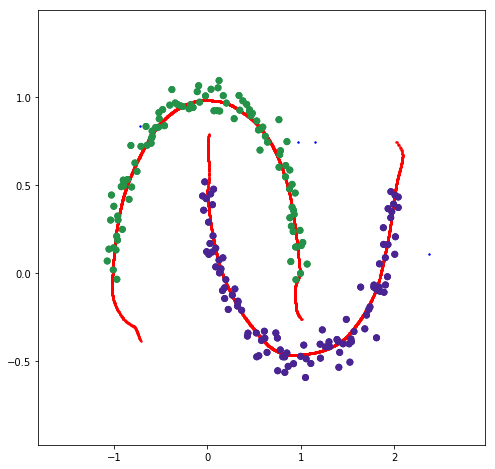

In [8]:
pth = os.path.join(project_dir, "varying_bandwidths")
os.makedirs(pth, exist_ok=1)
for (name, (data, c, dat)), (name2, (data2,c2,dat2)) in zip(converged,converged2):
    fig = plt.figure()
    
    plt.scatter(dat[:,0], dat[:,1], c='b',s=2)
    plt.scatter(data[:,0], data[:,1],c=cmap(c))
    
    plt.scatter(dat2[:,0], dat2[:,1], c='r',s=2)
    plt.scatter(data2[:,0], data2[:,1],c=cmap(c2))
    
    plt.xlim(*graph_bounds[:,0])
    plt.ylim(*graph_bounds[:,1])
    
    plt.savefig(os.path.join(pth, "{}.png".format(name)))

In [ ]:
example_moons, c = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
range_pct = 0.2
grid_steps = 100
KERNEL = local_models.local_models.GaussianKernel
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(example_moons)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

grid = local_models.utils.get_global_grid(example_moons, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
bandwidths = [0.2]
n = [200]
noise = np.linspace(0,20,256)
seed = [1]

converged = converge_parallel(functools.partial(noisy_moons_maker, kernel=KERNEL), grid, local_tls_shift_till_convergence, 
                                       bandwidth=bandwidths, n=n, noise=noise, seed=seed)

In [ ]:
pth = os.path.join(project_dir, "varying_noise")
os.makedirs(pth, exist_ok=1)
for name, (data, c, dat) in converged:
    fig = plt.figure()
    plt.scatter(dat[:,0], dat[:,1], c='r',s=2)
    plt.scatter(data[:,0], data[:,1],c=cmap(c))
    plt.xlim(*graph_bounds[:,0])
    plt.ylim(*graph_bounds[:,1])
    plt.savefig(os.path.join(pth, "{}.png".format(name)))

In [ ]:
example_moons, c = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
range_pct = 0.2
grid_steps = 100
KERNEL = local_models.local_models.GaussianKernel
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(example_moons)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

grid = local_models.utils.get_global_grid(example_moons, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
bandwidths = np.linspace(0.04,1.7,256)
n = [200]
noise = [0.6]
seed = [1]

converged = converge_parallel(functools.partial(noisy_moons_maker, kernel=KERNEL), grid, local_tls_shift_till_convergence, report=True,
                                       bandwidth=bandwidths, n=n, noise=noise, seed=seed)

In [ ]:
example_moons, c = sklearn.datasets.make_moons(n_samples=200, noise=0.1)
range_pct = 0.2
grid_steps = 100
KERNEL = local_models.local_models.GaussianKernel
data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(example_moons)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

grid = local_models.utils.get_global_grid(example_moons, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
bandwidths = np.linspace(0.04,1.7,256)
n = [200]
noise = [0.6]
seed = [1]

converged_m = converge_parallel(functools.partial(noisy_moons_maker, kernel=KERNEL), grid, local_mean_shift_till_convergence, report=True,
                                       bandwidth=bandwidths, n=n, noise=noise, seed=seed)

In [ ]:
converged[1][1][2]

In [ ]:
a